In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("../Results/RG-2021_final_data.csv")

In [3]:
input_features = ['transformedRank1', 'careerMatches1', 'careerWin%1', 'surfaceWin%1', 'tiebreakerWin%1', 'deciderWin%1', 'wearOut1', 'transformedRank2', 'careerMatches1', 'careerWin%2', 'surfaceWin%2', 'tiebreakerWin%2', 'deciderWin%2', 'wearOut2', 'careerH2H', 'h2hWin%1']

X = np.array(data[input_features])
y = np.array(data["Upset"])
odds = data[["Odds1","Odds2"]]

In [4]:
X_test = torch.from_numpy(X)
y_test = torch.from_numpy(y)

In [5]:
### Initialze the network

input_size = 16
output_size = 2            # Player's winning probability and variance in its prediction

model = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(input_size,output_size),
    nn.Sigmoid()
)

print(model)

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=16, out_features=2, bias=True)
  (2): Sigmoid()
)


In [6]:
model.load_state_dict(torch.load("../Results/model_weights.pt"))

<All keys matched successfully>

In [7]:
def customLoss(y_pred,y):
    y_pred = torch.max(0.001*torch.ones_like(y_pred),y_pred)
    prob = y_pred[:,0].unsqueeze(1)
    var = y_pred[:,1].unsqueeze(1)
    # torch.mean(F.binary_cross_entropy(prob,y,reduction='none')/var + var)
    return  torch.mean(F.binary_cross_entropy(prob,y,reduction='none')/(100*var) + var)

criterion = customLoss

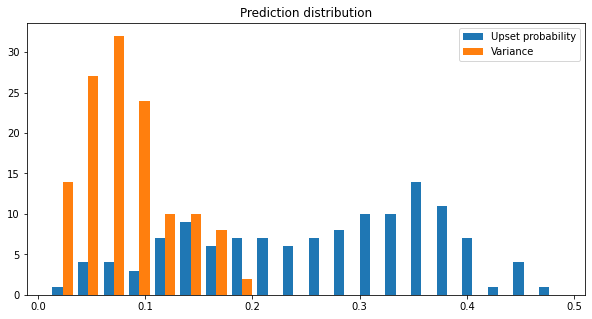

In [8]:
y_pred = model(X_test.float())
predictions = y_pred.detach().numpy()

plt.figure(figsize=(10,5))
plt.hist(predictions,bins=20)
plt.title("Prediction distribution")
plt.legend(["Upset probability","Variance"])
plt.show()

In [9]:
odds_test = odds.copy(deep=True)
odds_test = odds_test.reset_index()
odds_test.drop(columns=["index"],inplace=True)

final_data = pd.DataFrame()
final_data["Predicted prob"] = predictions[:,0]
final_data["Predicted variance"] = predictions[:,0]
final_data["Odds1"] = odds_test["Odds1"]
final_data["Odds2"] = odds_test["Odds2"]
final_data["Result"] = y_test

In [10]:
final_data.to_csv("../Results/RG-2021_upset_probs.csv",index=None)